<a href="https://colab.research.google.com/github/AshwinUnnikrishnan/DeepLearning7150/blob/main/HW3/HW3_2_Generative_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This can be [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-3/blob/main/HW3.2-Generative_DAE.ipynb)

# Generating Images with Denoising Autoencoder

In this homework, let's see how one can generate samples from a denoising autoencoder (DAE).

More info on DAE:
1. Good article on various autoencoders [Link](https://towardsdatascience.com/autoencoders-and-the-denoising-feature-from-theory-to-practice-db7f7ad8fc78) 



## Denoising Autoencoder (DAE)

Denoising Autoencoders are a class of autoencoders where we attempt to remove noise from a customized data. Note the emphasis on the word `customized`. Given that we train a DAE on a particular dataset, it is optimized to remove dataset from the samples of that dataset only and will not be suitable on other dataset samples. (Want to learn more on EBM models? Read more on [Energy Based Models](http://yann.lecun.com/exdb/publis/pdf/lecun-06.pdf))

So let's code a simple DAE and explore it's functioning !

In [ ]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth

--2022-10-08 19:42:11--  https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth
Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1078198 (1.0M)
Saving to: ‘mnist-classify.pth’

     0K .......... .......... .......... .......... ..........  4%  628K 2s
    50K .......... .......... .......... .......... ..........  9% 1.31M 1s
   100K .......... .......... .......... .......... .......... 14% 8.03M 1s
   150K .......... .......... .......... .......... .......... 18% 1.50M 1s
   200K .......... .......... .......... .......... .......... 23% 25.9M 1s
   250K .......... .......... .......... .......... .......... 28% 11.6M 0s
   300K .......... .......... .......... .......... .......... 33% 32.8M 0s
   350K .......... .......... .......... .......... .......... 37% 13.1M 0s
   400K .......... .......... .......... ......

In [ ]:
# Importing libraries
import matplotlib.pyplot as plt

import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
# downloading mnist into folder
data_dir = 'data' # make sure that this folder is created in your working dir
# transform the PIL images to tensor using torchvision.transform.toTensor method
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
print(f'Datatype of the dataset object: {type(train_data)}')
# check the length of dataset
print(f'Number of samples in training data: {len(train_data)}')
print(f'Number of samples in test data: {len(test_data)}')
# Check the format of dataset
print(f'Foramt of the dataset: \n {train_data}')

Datatype of the dataset object: <class 'torchvision.datasets.mnist.MNIST'>
Number of samples in training data: 60000
Number of samples in test data: 10000
Foramt of the dataset: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Displaying the loaded dataset

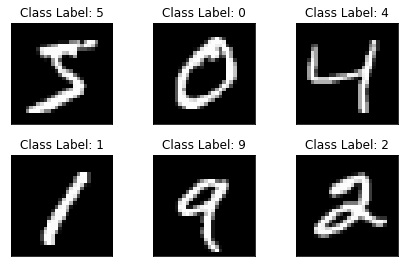

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])



## Building a DAE
We are going to build the DAE a little different this time. We are going to separately build the encoder and decoder and then call a model that connects them.

In [ ]:
class encoder(nn.Module):
    def __init__(self, encoded_dim=4, hidden_lin_dim=128,device='cuda'):
        super().__init__()
        # Encoder
        self.enc_conv1  = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=2,padding=1) # output shape 8x16x16
        self.enc_conv2  = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1) # output shape 16x8x8
        self.enc_conv3  = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=2,padding=0) # output shape 32x3x3
        # Encoder Flatten
        self.enc_flat   = nn.Flatten(start_dim=1)
        self.enc_lin1   = nn.Linear(in_features=32*3*3, out_features=hidden_lin_dim) 
        self.enc_lin2   = nn.Linear(in_features=hidden_lin_dim, out_features=encoded_dim) 
        
    def forward(self, inp):
        # encoder
        ## block1
        x = self.enc_conv1(inp)
        x = nn.ReLU()(x)
        ## block2
        x = self.enc_conv2(x)
        x = nn.BatchNorm2d(16,device=device)(x)
        x = nn.ReLU()(x)
        ## block3
        x = self.enc_conv3(x)
        x = nn.ReLU()(x)
        ## Flatten the encoding
        x = self.enc_flat(x)
        x = self.enc_lin1(x)
        x = nn.ReLU()(x)
        x = self.enc_lin2(x)
        return x

class decoder(nn.Module):
    def __init__(self, encoded_dim=4, hidden_lin_dim=128,device='cuda'):
        super().__init__()
        # Decoder Flatten
        self.dec_lin1   = nn.Linear(in_features=encoded_dim, out_features=hidden_lin_dim) 
        self.dec_lin2   = nn.Linear(in_features=hidden_lin_dim, out_features=32*3*3)
        self.dec_unflat = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
    def forward(self,inp):
        # decoder
        ## Flatenned decoding
        x = self.dec_lin1(inp)
        x = nn.ReLU()(x)
        x = self.dec_lin2(x)
        x = nn.ReLU()(x)
        x = self.dec_unflat(x)
        ## block1
        x = self.dec_conv1(x)
        x = nn.BatchNorm2d(16,device=device)(x)
        x = nn.ReLU()(x)
        ## block2
        x = self.dec_conv2(x)
        x = nn.BatchNorm2d(8,device=device)(x)
        x = nn.ReLU()(x)
        ## block3
        x = self.dec_conv3(x)
        x = torch.sigmoid(x)
        return x

## Function to add noise to data

In [ ]:
def add_noise(inp,noise_factor=0.3):
    noise = torch.rand(inp.shape) # Creating a noise in the same shape as input 
    noisy_image = inp + noise 
    return noisy_image

## Functions to train and test the DAE

In [ ]:
# Test function
def train_dae(enc, dec, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set the models to train
    enc.train()
    dec.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for images, labels in dataloader: # the variable `labels` willbe used for customised training
        # Add noise to images
        noisy = add_noise(images, noise_factor)
        # move the data to preferred device GPU/CPU
        images = images.to(device)
        noisy = noisy.to(device)    
        # send the noisy data through DAE to denoise
        ## encode the noisy image
        encoded = enc(noisy)
        ## decode the data to generate denoised image
        denoised_images = dec(encoded)
        # Evaluate loss
        loss = loss_fn(denoised_images, images)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
# Testing Function
def test_dae(enc, dec, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    enc.eval()
    dec.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        denoised = []
        actual = []
        for images, labels in dataloader:
            # Add noise to images
            noisy = add_noise(images, noise_factor)
            # move the data to preferred device GPU/CPU
            images = images.to(device)
            noisy = noisy.to(device)    
            # send the noisy data through DAE to denoise
            ## encode the noisy image
            encoded = enc(noisy)
            ## decode the data to generate denoised image
            denoised_images = dec(encoded)
            # Append the network output and the original image to the lists
            denoised.append(denoised_images.cpu())
            actual.append(images.cpu())
        # Create a single tensor with all the values in the lists
        denoised = torch.cat(denoised)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(denoised, actual)
    return val_loss.data

## Function to plot results

In [ ]:
def plot_dae_inference(encoder, decoder, test_dataset, n=10, noise_factor=0.3):
    plt.figure(figsize=(15,5))
    labels = test_dataset.targets.numpy()
    idx = {i:np.where(labels==i)[0][0] for i in range(n)}    
    for i in range(n):

        ax = plt.subplot(3,n,i+1)
        ax.set(facecolor = "white")
        image = test_dataset[idx[i]][0].unsqueeze(0)
        noisy = add_noise(image, noise_factor)     
        noisy = noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            denoised_image  = decoder(encoder(noisy))

        plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')  
        if i == n//2:
            ax.set_title('Actual Image')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy.cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')  
        if i == n//2:
            ax.set_title('Corrupted Image')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(denoised_image.cpu().squeeze().numpy(), cmap='gray')  
        ax.axis('off')   
        if i == n//2:
            ax.set_title('Denoised Image')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     

    plt.tight_layout()
    plt.show()   

## Initializing the models, optimizer and loss function. Load the model to CPU/GPU device

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)
# Choosing a device based on the env and torch setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


### Initialize the two networks
encoded_dim = 4
hidden_lin_dim = 128

enc = encoder(encoded_dim=encoded_dim, hidden_lin_dim=hidden_lin_dim, device=device)
dec = decoder(encoded_dim=encoded_dim, hidden_lin_dim=hidden_lin_dim, device=device)
# Move both the encoder and the decoder to the selected device
enc.to(device)
dec.to(device)


params_to_optimize = [
    {'params': enc.parameters()},
    {'params': dec.parameters()}
]
### Define the loss function
loss_fn = torch.nn.MSELoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001



optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)



Selected device: cuda


DAE training started
---------------------------------------------Epoch 1/30---------------------------------------------

 	 	 	 train loss 0.024 	 val loss 0.024


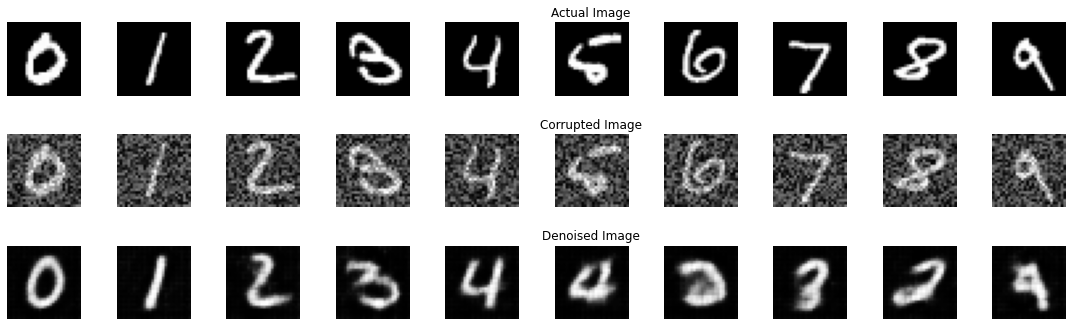

---------------------------------------------Epoch 2/30---------------------------------------------


TypeError: ignored

In [ ]:
### Intialize dataloaders
val_split = .2
batch_size=256 
include_samples = [0,1,2,3,4] # to ensure customised training

indices = [idx for idx, target in enumerate(train_data.targets) if target in include_samples]
train_data_new = Subset(train_data, indices) # Only include samples
n_train_samples = len(train_data_new)
train_data_, val_data = random_split(train_data_new, [int(n_train_samples*(1-val_split)), int(n_train_samples*val_split)+1])


train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

### Training cycle
noise_factor = 0.3
num_epochs = 30
history={'train_loss':[],'val_loss':[]}

print('DAE training started')
for epoch in range(num_epochs):
    ### Training 
    print(f'---------------------------------------------Epoch {epoch+1}/{num_epochs}---------------------------------------------')
    train_loss=train_dae(
        enc=enc, 
        dec=dec, 
        device=device, 
        dataloader=train_loader,
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_dae(
        enc=enc, 
        dec=dec, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    print('\n \t \t \t train loss {:.3f} \t val loss {:.3f}'.format(train_loss,val_loss))
    plot_dae_inference(enc,dec,test_dataset=test_data,noise_factor=noise_factor)
print('DAE training done!')

So far we have repeated the DAE training from hw2.2. Now let's start the exercise of generating MNIST samples from DAE

## Can you generate from DAE?

Exercise 3.2.1: We have a trained DAE model that was trained on subset of MNIST. Use the trained decoder to generate samples. How? Follow these steps:
- Set the models to eval
- with torch.no_grad, take a few samples from test dataloader and pass through encoder
- Calculate the mean and standard deviation of the output of the encoder 
- Generate some random numbers (of size 100) with mean and std from above
- Pass the random numbers through the decoder and display 10 of the results

In [ ]:
def generateRandomInputs(n, overallMean, stdVal, meanMultiplier=1, stdMultiplier=1):
    randomInputs_Column1 = torch.empty((n)).normal_(mean=overallMean[0].item()*meanMultiplier,std=stdVal[0]*stdMultiplier).to(device)
    randomInputs_Column2 = torch.empty((n)).normal_(mean=overallMean[1].item()*meanMultiplier,std=stdVal[1]*stdMultiplier).to(device)
    randomInputs_Column3 = torch.empty((n)).normal_(mean=overallMean[2].item()*meanMultiplier,std=stdVal[2]*stdMultiplier).to(device)
    randomInputs_Column4 = torch.empty((n)).normal_(mean=overallMean[3].item()*meanMultiplier,std=stdVal[3]*stdMultiplier).to(device)

    return(torch.stack((randomInputs_Column1,randomInputs_Column2,randomInputs_Column3, randomInputs_Column4), -1))


In [325]:
def plot_dae_inference_custom(encoder, decoder, images, labels, n=10, noise_factor=0.3, meanMultiplier = 1, stdMultiplier = 1, printVal = True, denoisedReturn = False):
    images = images.cuda()
    # Setting to eval
    enc.eval()
    dec.eval()
    # Encoding for a batch size of 256
    with torch.no_grad():

      output_encoder = enc(images)
    # calculating the individual Mean and std for each of the 4 output vectors
    overallMean = output_encoder.mean(0).cpu()
    stdVal = torch.std(output_encoder, unbiased=False, dim = 0).cpu()
    if printVal:
      print("mean = {0}".format(overallMean))
      print("std = {0}".format(stdVal))
    

    # Generating n such inputs to the decoder from mean and std of each feature
    denoisedInput = generateRandomInputs(n, overallMean, stdVal, meanMultiplier= meanMultiplier, stdMultiplier= stdMultiplier)    


    print(denoisedInput.shape)
    
    # Sending the randomly created input throw decoder
    with torch.no_grad():

      denoisedImage = dec(denoisedInput)
    
    if printVal:
      plt.figure(figsize=(15,5))

      # Plotting the output to image
      generatedImages = []
      for i in range(n):
        generatedImages.append(denoisedImage[i])
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(denoisedImage[i].cpu().squeeze().numpy(), cmap='gray')  
        ax.axis('off')   
      
      plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.7, 
                        top=0.9, 
                        wspace=0.3, 
                        hspace=0.3)     

      plt.tight_layout()
      plt.show()   
    else:
      generatedImages = []
      for i in range(n):
        generatedImages.append(denoisedImage[i])

    if denoisedReturn == True:
      return overallMean, stdVal, torch.stack(generatedImages), denoisedInput
    return overallMean, stdVal, torch.stack(generatedImages)

mean = tensor([-0.2096,  0.0722,  0.0961,  0.0326])
std = tensor([0.6127, 0.5314, 0.4505, 0.6095])
torch.Size([10, 4])


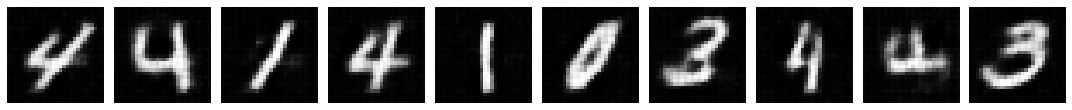

torch.Size([10, 1, 28, 28])


In [315]:
images, labels = next(iter(test_loader))
overallMean, stdVal, generatedImages = plot_dae_inference_custom(enc, dec, images, labels)

print(generatedImages.shape)

Exercise 3.2.2: Now generate in the same way as above, except when you generate some random numbers use a very different mean and std (eg: 7 $\times$ mean and 8 $\times$ std). Show the results 

mean = tensor([-0.2096,  0.0722,  0.0961,  0.0326])
std = tensor([0.6127, 0.5314, 0.4505, 0.6095])
torch.Size([10, 4])


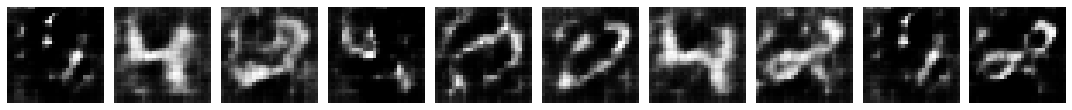

In [316]:
# set both the encoder and decoder to eval

# take some images from test_loader (hint: use `iter`)

# Pass them through encoder

# Calculate mean and std of the output

# Generate random numbers with different mean and std from above step (eg: 7*mean and 8*std)

# Pass through decoder

# Display the results
images, labels = next(iter(test_loader))
x,y,z = plot_dae_inference_custom(enc, dec, images, labels, meanMultiplier=7, stdMultiplier=8)

What are your observations about the samples generated?

* **When we take create random input for decoder from the given range of mean and std of vector at the end of encoder, we have similar kind of output by decoder where we get a denoised image**
* **But when we multiply the mean and std by different values and generate input of the decoder based on the newly calculated mean and std, we see that the decoder does not perform a good denoising. That is because the trained dataset is different from what it sees after changing the mean and std.**

## Diversity in Generations
In this exercise, we will check how well our generated samples are distributed. In other words, we are going to check the classes generated by our model. Is it generating certain classes more or is it very well distributed. We are going to classify our outputs using a pretrained MNIST classifier that is opensourced. Why? Because you generated these samples from random numbers, we do not have labels for them. So let's get deep neural nets to do the work of counting the classes for us!

Pretrained MNSIT classification model from [ML CS Tsinghua](https://github.com/aaron-xichen/pytorch-playground)

In [ ]:
from collections import OrderedDict
class MNIST_Classifier(nn.Module):
    '''
    Pretrained model by  ML CS Tsinghua's Aaron et al.(https://github.com/aaron-xichen/pytorch-playground)
    '''
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        self.input_dims = 784
        self.n_classes = 10
        current_dims = self.input_dims
        layers = OrderedDict()
        n_hiddens = [256,256]
        for i, n_hidden in enumerate(n_hiddens):
            layers['fc{}'.format(i+1)] = nn.Linear(current_dims, n_hidden)
            layers['relu{}'.format(i+1)] = nn.ReLU()
            layers['drop{}'.format(i+1)] = nn.Dropout(0.2)
            current_dims = n_hidden
        layers['out'] = nn.Linear(current_dims, self.n_classes)

        self.model= nn.Sequential(layers)

    def forward(self, input):
        input = input.view(input.size(0), -1)
        assert input.size(1) == self.input_dims
        return self.model.forward(input)

<b>Exercise 3.2.3:</b> Use the generated images from above (from exercise 3.2.1) and run them through `evaluate_samples_classify` function. 

torch.Size([1000, 4])
torch.Size([1000, 1, 28, 28])
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[221, 138, 144, 195, 246, 2, 4, 35, 9, 6]
Done!


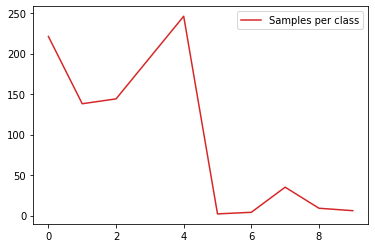

In [ ]:
# Use the classfication model above and classify all the generated images (for this exercise generate 1000 samples)
overallMean, stdVal, generatedImages = plot_dae_inference_custom(enc, dec, images, labels,n=1000, printVal=False)
print(generatedImages.shape)
# Call the `MNIST_Classifier` model.
device = torch.device("cuda")
model = MNIST_Classifier()
# Load the pre-trained weights given to you along with this homework ('mnist_classify.pth') [hint: check out load_state_dict]
model.load_state_dict(torch.load('mnist-classify.pth'))
model.to(device)
model.eval()


# predict the class [Hint: Look for the maximum value of output.]


count = [0]*10
print(count)
result = model(generatedImages.cuda())

for res in range(len(result)):
  count[torch.argmax(result[res]).item()] += 1

print(count)

# For each class predicted, plot the number of samples. For example, your classifier found 20 out of 1000 samples as class '9'

plt.plot(range(10),count, color ='tab:red', label='Samples per class')
plt.legend()
print("Done!")

<b> Extra Credit (Optional)</b>

If you have finished the above exercises, you will get full credit! This one is for extra credit.

Visualizing the random latent space responsible for generation. Read the instructions completely before starting
- Take some MNIST images (20, 2 per each class). Pass through encoder. Store the encoded samples
- Generate some random numbers(20) and pass through decoder. Store the random numbers as they are the encodings to the generated images.
- Generate some bad random number(20) and pass through decoder. Store the random numbers.
- Now visualize these encoded representations. How? If their size were 2, you could have plotted them on scatter plot. That's something you can do in 2 ways.
    - Build the encoder and decoder, but this time with encoding dimension as 2 instead of 4. Then plot them as scatter plot. To distinguish them, use markers and colors. 
    - Use the same models, except the saved encoded representations are size 4 arrays. So use t-SNE to reduce dimensions to 2. Plot the reduced representation. (Minimal coding to do)

In [298]:
def getData(test_data_custom):
  labels = test_data.targets.numpy()
  idx = {i:np.where(labels==i)[0][0:2] for i in range(10)}
  resultIndices = []
  for keys, val in idx.items():
    for values in val:
      resultIndices.append(values)
  return resultIndices

In [306]:
# Get data 2 from each label
requiredIndices = getData(test_data)
test_data_new = Subset(test_data, requiredIndices) # Only include samples
n_test_samples = len(test_data_new)
print(n_test_samples)
test_loader_extra = torch.utils.data.DataLoader(test_data_new, batch_size=batch_size,shuffle=True)

20


mean = tensor([-0.2096,  0.0722,  0.0961,  0.0326])
std = tensor([0.6127, 0.5314, 0.4505, 0.6095])
torch.Size([20, 4])


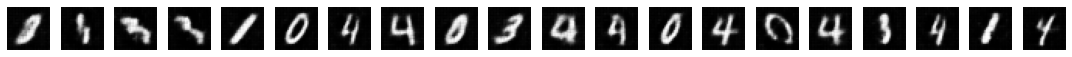

In [327]:
images, labels = next(iter(test_loader_extra))
overallMean, stdVal, goodGeneratedImages, encodedRandomGood = plot_dae_inference_custom(enc, dec, images, labels, n=20, denoisedReturn = True)

mean = tensor([-0.2096,  0.0722,  0.0961,  0.0326])
std = tensor([0.6127, 0.5314, 0.4505, 0.6095])
torch.Size([20, 4])


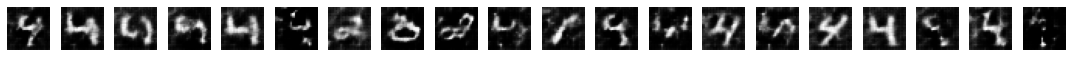

In [328]:
images, labels = next(iter(test_loader_extra))
overallMean, stdVal, badGeneratedImages, encodedRandomBad = plot_dae_inference_custom(enc, dec, images, labels, n=20, stdMultiplier=5, meanMultiplier=9, denoisedReturn = True)

### Trying to do t-sne

In [329]:
from sklearn.manifold import TSNE

In [332]:
# Having two different not sure if having same things effect the results
X_embedded_Good = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
X_embedded_Bad = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)

# n_components we need to make 4 to 2 so we set it as 2

In [336]:
reducedEncodedRandomGood = X_embedded_Good.fit_transform(encodedRandomGood.cpu())
reducedEncodedRandomBad = X_embedded_Bad.fit_transform(encodedRandomBad.cpu())

In [337]:
# Checking the updated shape
print(reducedEncodedRandomGood.shape)
print(reducedEncodedRandomBad.shape)

(20, 2)
(20, 2)


In [344]:
reducedEncodedRandomGood

array([[ 29.735413 ,  41.54162  ],
       [  8.671294 , -15.188132 ],
       [  8.338537 , -73.9288   ],
       [ 12.755171 , -75.74565  ],
       [ 24.050005 ,  52.03885  ],
       [ 38.189617 ,  27.835247 ],
       [  3.1325982, -29.999796 ],
       [ -2.9006598, -58.250397 ],
       [ 32.41854  ,  36.572872 ],
       [ 28.736095 ,  47.186405 ],
       [  2.7747564, -50.113888 ],
       [  8.197044 , -33.326946 ],
       [ 33.194195 ,  29.755688 ],
       [ -5.409893 , -45.36058  ],
       [  1.5314873, -71.03779  ],
       [ -2.6401312, -51.19408  ],
       [  9.088768 , -10.422643 ],
       [ -0.6073203, -26.858477 ],
       [ 19.950014 ,  57.03856  ],
       [-10.78567  , -39.039787 ]], dtype=float32)

In [347]:
reducedEncodedRandomGood[:,0]

array([ 29.735413 ,   8.671294 ,   8.338537 ,  12.755171 ,  24.050005 ,
        38.189617 ,   3.1325982,  -2.9006598,  32.41854  ,  28.736095 ,
         2.7747564,   8.197044 ,  33.194195 ,  -5.409893 ,   1.5314873,
        -2.6401312,   9.088768 ,  -0.6073203,  19.950014 , -10.78567  ],
      dtype=float32)

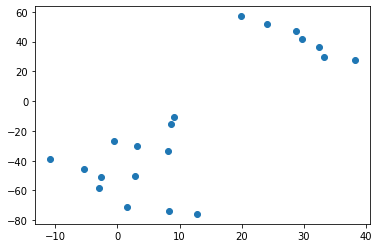

In [345]:
plt.scatter(reducedEncodedRandomGood[:,0], reducedEncodedRandomGood[:,1])
plt.show()

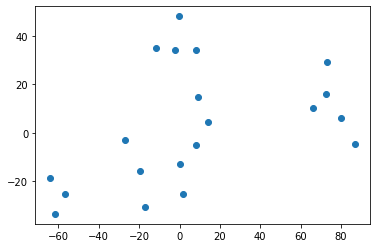

In [346]:
plt.scatter(reducedEncodedRandomBad[:,0], reducedEncodedRandomBad[:,1])
plt.show()

We can see the one with normal mean and std is more organized than the one with the mean and std multiplied by constant > 1.